In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

In [2]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("dataset/try_replace_with_rank.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    sum = 0
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        sum += len(df)
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']
sum

S_1
S_2
S_3
S_4
S_5
S_6


8348

## Tiles

## calculate tile_size

In [9]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

train_spacing_per_slide = {}

for slide_id, df in train_spot_tables.items():
    coords = df[['x', 'y']].values
    if len(coords) < 2:
        print(f"⚠️ Slide {slide_id} has less than 2 spots, skipping.")
        continue

    dist_matrix = squareform(pdist(coords))
    np.fill_diagonal(dist_matrix, np.inf)
    min_dists = dist_matrix.min(axis=1)
    mean_spacing = min_dists.mean()

    train_spacing_per_slide[slide_id] = mean_spacing
    print(f"📏 {slide_id}: Average spot distance = {mean_spacing:.2f} pixels")




📏 S_1: Average spot distance = 25.90 pixels
📏 S_2: Average spot distance = 25.91 pixels
📏 S_3: Average spot distance = 25.20 pixels
📏 S_4: Average spot distance = 25.02 pixels
📏 S_5: Average spot distance = 25.01 pixels
📏 S_6: Average spot distance = 25.24 pixels


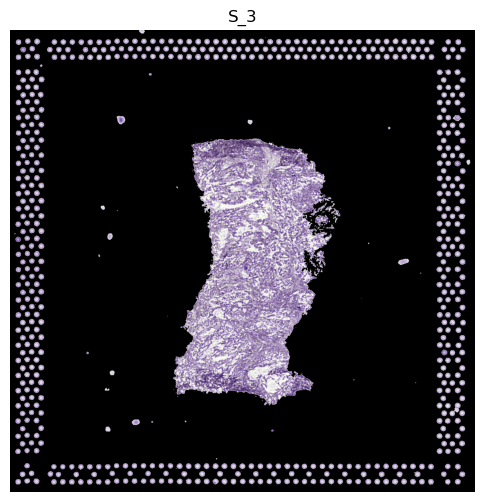

In [24]:
with h5py.File("dataset/try_realign.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    
    sample = 'S_3'
    image = np.array(train_images[sample])
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.axis('off')
    plt.title(sample)
    plt.show()


🔍 所有 slide tile size 78 pixels
Found 8 spots in this tile.
       x    y
183  909  738
258  884  738
303  909  783
437  896  760
459  858  738
526  858  783
530  884  783
607  845  760
871 760


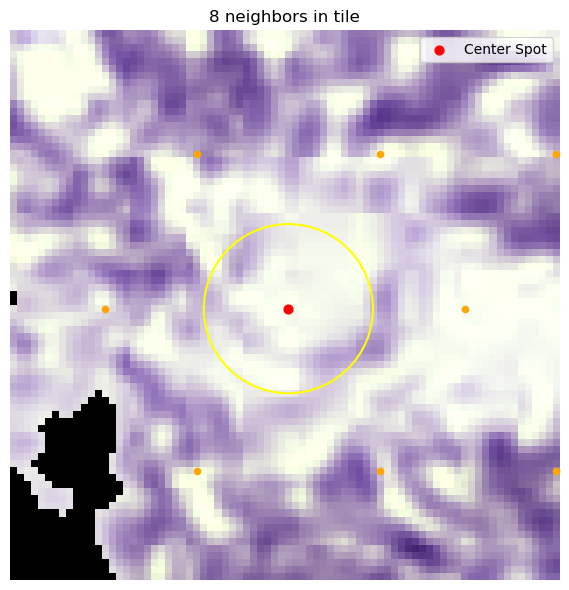

In [50]:
import random
from scripts.tile_image import get_spots_in_tile, plot_tile_with_spots
tile_size = round(max(train_spacing_per_slide.values())*3)  # → round(77.7) → 78
print(f"\n🔍 所有 slide tile size {tile_size} pixels")

df = train_spot_tables['S_3']
i = random.randint(0, len(df) - 1)

row = df.iloc[i]

x = row['x']
y = row['y']

# 取得tile範圍內的spot們
neighbors_df = get_spots_in_tile(df, x, y, tile_size=78)

print(f"Found {len(neighbors_df)} spots in this tile.")
print(neighbors_df[['x', 'y']])
print(x,y)
plot_tile_with_spots(
    slide_image=image,
    spot_df=neighbors_df,
    center_x=x,
    center_y=y,
    tile_size=78,
    #grid_size=3,
    spot_radius_px=12
)


# Test data preparation

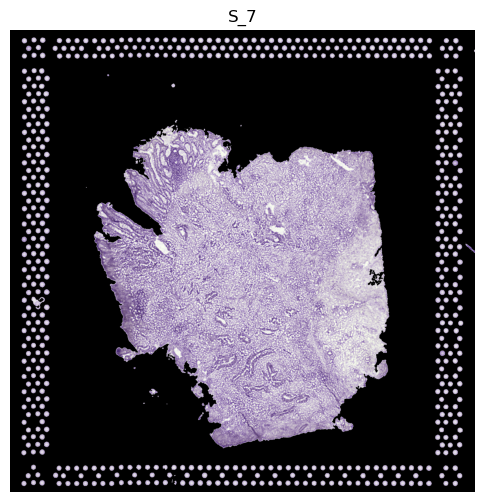

In [6]:
# Visualize Test slide ('S_7')
with h5py.File("dataset/try1_masked.h5", "r") as h5file:
    test_images = h5file["images/Test"]

    sample = 'S_7'
    image = np.array(test_images[sample])
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [7]:
# Display spot table for Test slide (only the spot coordinates on 2D array)
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    print(test_spots.keys())
    spot_array = np.array(test_spots['S_7'])
    test_spot_table = pd.DataFrame(spot_array)
    
# Show the test spots coordinates for slide 'S_7'
test_spot_table

<KeysViewHDF5 ['S_7']>


,x,y,Test_Set
0,1499,1260,2
1,1435,1503,2
2,558,1082,2
3,736,1304,1
4,1257,1592,1
...,...,...,...
2083,736,639,2
2084,1016,684,2
2085,1181,839,2
2086,735,1436,1


In [10]:
coords = test_spot_table[['x', 'y']].values
# 計算距離矩陣（所有 spot 之間）
dist_matrix = squareform(pdist(coords))  # shape = (N, N)

# 把對角線設為無限大（自己對自己不算）
np.fill_diagonal(dist_matrix, np.inf)

# 取得每個 spot 最近的一個鄰居距離
min_dists = dist_matrix.min(axis=1)

# 算平均距離
mean_spacing = min_dists.mean()

print(f"Average spot distance {mean_spacing:.2f} pixels")

Average spot distance 25.01 pixels
